In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('ticks')

import glob
import re
import json 
import itertools
import functools 
import pickle

mpl.rc('font', family='Arial', size=14)

# Annotating DRIP peaks based on mouse mm10 gene annotations

In [ ]:
#Intersect mm10 genes with DRIP peaks
!bedtools intersect -wao -a hepa_peaks.bed -b mm10_3kb_slop_genes.bed > hepa_peaks_slop_3kb_full_genes.tsv
!bedtools intersect -wao -a liver_peaks.bed -b mm10_3kb_slop_genes.bed > liver_peaks_slop_3kb_full_genes.tsv

In [2]:
#read in intersect file
liver_int = pd.read_csv('liver_peaks_slop_3kb_full_genes.tsv', 
                          sep='\t', names = ['peak_chr', 'peak_start', 'peak_end', 'peak_name', 'peak_value', 'peak_strand', 'gene_chr', 'gene_start', 
                                             'gene_end', 'gene_name', 'gene_value', 'gene_strand', 'overlap'])

In [3]:
liver_int.head(12)




,peak_chr,peak_start,peak_end,peak_name,peak_value,peak_strand,gene_chr,gene_start,gene_end,gene_name,gene_value,gene_strand,overlap
0,chr1,3888979,3889223,liver_mapq_IP_vs_IN_peak_1,10,.,.,-1,-1,.,-1,.,0
1,chr1,4373648,4374193,liver_mapq_IP_vs_IN_peak_2,10,.,chr1,4289980,4412187,ENSMUST00000194992.6,0,-,545
2,chr1,4373648,4374193,liver_mapq_IP_vs_IN_peak_2,10,.,chr1,4287845,4412241,ENSMUST00000208793.1,0,-,545
3,chr1,4373648,4374193,liver_mapq_IP_vs_IN_peak_2,10,.,chr1,3996556,4412241,ENSMUST00000208660.1,0,-,545
4,chr1,4785212,4785912,liver_mapq_IP_vs_IN_peak_3,15,.,chr1,4776966,4787566,ENSMUST00000192286.1,0,-,700
5,chr1,4785212,4785912,liver_mapq_IP_vs_IN_peak_3,15,.,chr1,4780571,4788692,ENSMUST00000132625.1,0,-,700
6,chr1,4785212,4785912,liver_mapq_IP_vs_IN_peak_3,15,.,chr1,4771435,4788698,ENSMUST00000045689.13,0,-,700
7,chr1,4785212,4785912,liver_mapq_IP_vs_IN_peak_3,15,.,chr1,4770205,4788710,ENSMUST00000130201.7,0,-,700
8,chr1,4785212,4785912,liver_mapq_IP_vs_IN_peak_3,15,.,chr1,4770210,4788739,ENSMUST00000156816.6,0,-,700
9,chr1,4785212,4785912,liver_mapq_IP_vs_IN_peak_3,15,.,chr1,4773376,4788739,ENSMUST00000115538.4,0,-,700


In [4]:
# Assign each peak a strand based on the intersecting gene
liver_int['peak_strand'] = liver_int['gene_strand']

# This previous command doesn't necessarily assign a unique strand
# As some peaks intersect multiple genes. Here, we put the peaks
# and genes on a one-to-one correspondence, 
liver_int = (liver_int
             .sort_values('gene_value', ascending=False)
             .drop_duplicates(['peak_chr', 'peak_start', 'peak_end'])
             .sort_values(['peak_chr', 'peak_start', 'peak_end'])
            )

In [5]:
liver_genic = liver_int.loc[(liver_int.peak_strand == '+') | (liver_int.peak_strand == '-'),:]
liver_intergenic = liver_int.loc[(liver_int.peak_strand == '.'),:]


In [6]:
print('liver_intergenic:' + str(len(liver_intergenic)))
print('liver_genic:' + str(len(liver_genic)))

liver_intergenic:2006
liver_genic:17723


In [7]:
#read in intersect file
hepa_int = pd.read_csv('hepa_peaks_slop_3kb_full_genes.tsv', 
                          sep='\t', names = ['peak_chr', 'peak_start', 'peak_end', 'peak_name', 'peak_value', 'peak_strand', 'gene_chr', 'gene_start', 
                                             'gene_end', 'gene_name', 'gene_value', 'gene_strand', 'overlap'])

In [8]:
# Assign each peak a strand based on the intersecting gene
hepa_int['peak_strand'] = hepa_int['gene_strand']

# This previous command doesn't necessarily assign a unique strand
# As some peaks intersect multiple genes. Here, we put the peaks
# and genes on a one-to-one correspondence, 
hepa_int = (hepa_int
             .sort_values('gene_value', ascending=False)
             .drop_duplicates(['peak_chr', 'peak_start', 'peak_end'])
             .sort_values(['peak_chr', 'peak_start', 'peak_end'])
            )

In [9]:
hepa_genic = hepa_int.loc[(hepa_int.peak_strand == '+') | (hepa_int.peak_strand == '-'),:]
hepa_intergenic = hepa_int.loc[(hepa_int.peak_strand == '.'),:]
print('hepa_genic:' + str(len(hepa_genic)))
print('hepa_intergenic:' + str(len(hepa_intergenic)))

hepa_genic:29697
hepa_intergenic:1022


In [10]:
def write_bed(df, filename):
    (df[['peak_chr', 'peak_start', 'peak_end', 'peak_name', 'peak_value', 'peak_strand']]
     .sort_values(['peak_chr', 'peak_start', 'peak_end'])
     .to_csv(filename, sep='\t', index=False, header=False)
    )

In [11]:
write_bed(hepa_int, 'hepa_annotated_peaks.bed')
write_bed(liver_int, 'liver_annotated_peaks.bed')


# Aggregate plots around the TSS and TES

In [2]:
mat_tss = glob.glob('*.matrix')

In [4]:
sample_extractor = re.compile('/([^/]+)\.matrix')

In [5]:
filename_correspondence_tss = {i: sample_extractor.findall(i)[0] for i in mat_tss}

In [7]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str).str.cat(df.strand.astype(str), sep=';'), sep='-'), sep=':')

def read_full_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    #temp = temp[temp.iloc[:, 5] != '.']  #this removes all rows where peak strand is '.' i.e. intergenic peaks
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str).str.cat( 
                            temp.iloc[:, 5].astype(str), sep = ';'),
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    return temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)

# Plots over TSS

In [8]:
#dict containing genic and intergnic peaks
tss = {}

for filename, samplename in filename_correspondence_tss.items():
    print(samplename)
    tss[samplename] = read_full_file(filename)    

V1_RNH--2_L.rna_seq
V1_Input-1_L.rna_seq
V1_RNH--1_Hepa
V1_RNHplus-1_L
at_skew.mm10
V1_RNHplus-2_L.rna_seq
V1_Input-2_L.v25
V1_Input-2_L
at_skew.mm10.rna_seq
V1_Input-1_Hepa.v25
V1_RNH--2_Hepa.v25
V1_Input-1_Hepa.rna_seq
V1_RNH--1_L.v25
V1_Input-2_Hepa.rna_seq
V1_RNH--2_L
V1_RNH--2_Hepa
V1_RNHplus-2_Hepa.v25
gc_skew.mm10.rna_seq
V1_RNHplus-1_L.v25
V1_Input-1_L
V1_Input-2_Hepa
V1_RNH--2_L.v25
gc_skew.mm10
V1_Input-2_Hepa.v25
V1_RNHplus-2_L
V1_RNHplus-1_Hepa
V1_RNH--1_Hepa.rna_seq
V1_RNH--2_Hepa.rna_seq
V1_RNHplus-2_L.v25
V1_RNHplus-1_Hepa.rna_seq
V1_RNHplus-1_Hepa.v25
V1_RNHplus-2_Hepa.rna_seq
V1_Input-2_L.rna_seq
V1_RNH--1_L.rna_seq
V1_RNHplus-2_Hepa
V1_RNH--1_Hepa.v25
V1_RNH--1_L
V1_Input-1_L.v25
V1_RNHplus-1_L.rna_seq
V1_Input-1_Hepa


In [10]:
#combining replicates

tss['mean_hepa'] = (tss['V1_RNH--1_Hepa'] + tss['V1_RNH--2_Hepa'])/2
tss['mean_liver'] = (tss['V1_RNH--1_L'] + tss['V1_RNH--2_L'])/2


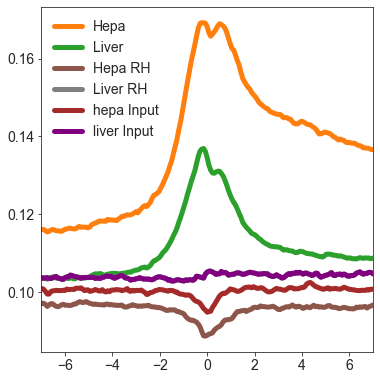

In [45]:
fig, ax = plt.subplots(ncols =1, nrows=1, figsize=(5.5,5.5))

X = np.arange(-7.5,7.5,0.075)

g= tss['mean_hepa'].loc[(tss['mean_hepa'].mean(axis=1) < tss['mean_hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
h= tss['mean_liver'].loc[(tss['mean_liver'].mean(axis=1) < tss['mean_liver'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
i= tss['V1_RNHplus-1_Hepa'].loc[(tss['V1_RNHplus-1_Hepa'].mean(axis=1) < tss['V1_RNHplus-1_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
j= tss['V1_RNHplus-1_L'].loc[(tss['V1_RNHplus-1_L'].mean(axis=1) < tss['V1_RNHplus-1_L'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
k= tss['V1_Input-1_Hepa'].loc[(tss['V1_Input-1_Hepa'].mean(axis=1) < tss['V1_Input-1_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
l= tss['V1_Input-1_L'].loc[(tss['V1_Input-1_L'].mean(axis=1) < tss['V1_Input-1_L'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
palette_tab10 = sns.color_palette("tab10", 10)

ax.set_xlim(-7, 7)
ax.set_yticks([0.08,0.10,0.12,0.14,0.16])
ax.set_xlabel('')
ax.set_ylabel('')
ax.plot(X, g, color = palette_tab10[1], label = 'Hepa', linewidth=5  )
ax.plot(X, h, color = palette_tab10[2], label = 'Liver', linewidth=5)

ax.plot(X, i, color =palette_tab10[5], label = 'Hepa RH', linewidth=5)
ax.plot(X, j, color =palette_tab10[7], label = 'Liver RH', linewidth=5)
ax.plot(X, k, color = 'brown', label = 'hepa Input', linewidth=5)
ax.plot(X, l, color = 'purple', label = 'liver Input', linewidth=5 )
ax.legend(frameon=False)


fig.tight_layout()
#fig.savefig('TSS_DRIP.svg')


In [17]:
#dict containing all TES
tes = {}

for filename, samplename in filename_correspondence_tes.items():
    print(samplename)
    tes[samplename] = read_full_file(filename)
    

V1_RNH--2_L.rna_seq
V1_Input-1_L.rna_seq
V1_RNH--1_Hepa
V1_RNHplus-1_L
at_skew.mm10
V1_RNHplus-2_L.rna_seq
V1_Input-2_L
at_skew.mm10.rna_seq
V1_Input-1_Hepa.rna_seq
V1_Input-2_Hepa.rna_seq
V1_RNH--2_L
V1_RNH--2_Hepa
gc_skew.mm10.rna_seq
V1_Input-1_L
V1_Input-2_Hepa
gc_skew.mm10
V1_RNHplus-2_L
V1_RNHplus-1_Hepa
V1_RNH--1_Hepa.rna_seq
V1_RNH--2_Hepa.rna_seq
V1_RNHplus-1_Hepa.rna_seq
V1_RNHplus-2_Hepa.rna_seq
V1_Input-2_L.rna_seq
V1_RNH--1_L.rna_seq
V1_RNHplus-2_Hepa
V1_RNH--1_L
V1_RNHplus-1_L.rna_seq
V1_Input-1_Hepa


In [18]:
#combining replicates

tes['mean_hepa'] = (tes['V1_RNH--1_Hepa'] + tes['V1_RNH--2_Hepa'])/2
tes['mean_liver'] = (tes['V1_RNH--1_L'] + tes['V1_RNH--2_L'])/2


NameError: name 'tes' is not defined

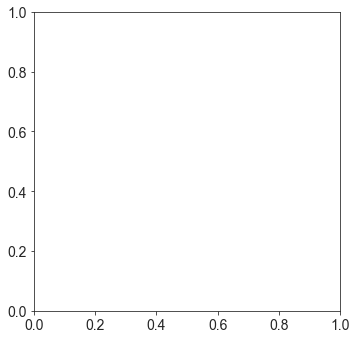

In [4]:
fig, ax = plt.subplots(ncols =1, nrows=1, figsize=(5.5,5.5))

X = np.arange(-7.5,7.5,0.075)

g= tes['mean_hepa'].loc[(tes['mean_hepa'].mean(axis=1) < tes['mean_hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
h= tes['mean_liver'].loc[(tes['mean_liver'].mean(axis=1) < tes['mean_liver'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
i= tes['V1_RNHplus-1_Hepa'].loc[(tes['V1_RNHplus-1_Hepa'].mean(axis=1) < tes['V1_RNHplus-1_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
j= tes['V1_RNHplus-1_L'].loc[(tes['V1_RNHplus-1_L'].mean(axis=1) < tes['V1_RNHplus-1_L'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
k= tes['V1_Input-1_Hepa'].loc[(tes['V1_Input-1_Hepa'].mean(axis=1) < tes['V1_Input-1_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
l= tes['V1_Input-1_L'].loc[(tes['V1_Input-1_L'].mean(axis=1) < tes['V1_Input-1_L'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
palette_tab10 = sns.color_palette("tab10", 10)

ax.set_xlim(-7, 7)
ax.set_yticks([0.08,0.10,0.12,0.14,0.16])
ax.set_xlabel('')
ax.set_ylabel('')
ax.plot(X, g, color = palette_tab10[1], label = 'Hepa', linewidth=5  )
ax.plot(X, h, color = palette_tab10[2], label = 'Liver',linewidth=5)

ax.plot(X, i, color =palette_tab10[5], label = 'Hepa RH',linewidth=5)
ax.plot(X, j, color =palette_tab10[7], label = 'Liver RH',linewidth=5 )
ax.plot(X, k, color = 'brown', label = 'hepa Input',linewidth=5)
ax.plot(X, l, color = 'purple', label = 'liver Input',linewidth=5 )
ax.legend(frameon=False)


fig.tight_layout()
fig.savefig('TES_DRIP.svg')

# Liver DRIP peaks center 

In [8]:
bed_cols = ['chr', 'start', 'end', 'name', 'value', 'strand']

hepa_peaks = pd.read_csv('hepa_annotated_peaks.bed', 
                          sep='\t', names = bed_cols)
liver_peaks = pd.read_csv('liver_annotated_peaks.bed', 
                          sep='\t', names = bed_cols)

hepa_only = pd.read_csv('hepa_only_peaks.bed', 
                          sep='\t', names = bed_cols)

liver_only = pd.read_csv('liver_only_peaks.bed', 
                          sep='\t', names = bed_cols)

hepa_peaks['ucsc_idx'] = ucsc_index(hepa_peaks)
liver_peaks['ucsc_idx'] = ucsc_index(liver_peaks)
hepa_only['ucsc_idx']= ucsc_index(hepa_only)
liver_only['ucsc_idx']= ucsc_index(liver_only)

hepa_peaks = set(hepa_peaks.loc[:, 'ucsc_idx'])
liver_peaks = set(liver_peaks.loc[:, 'ucsc_idx'])
hepa_only = set(hepa_only.loc[:, 'ucsc_idx'])
liver_only = set(liver_only.loc[:, 'ucsc_idx'])


In [9]:
len(hepa_peaks)

28717

In [10]:
len(liver_peaks)

14908

In [11]:
len(hepa_only)

19580

In [12]:
len(liver_only)

3598

In [14]:
liver_center = glob.glob('/deeptools_liver_bin75/*.matrix')
filename_correspondence_liver_center = {i: sample_extractor.findall(i)[0] for i in liver_center}

In [15]:
#dict containing genic and intergnic peaks
liver_center = {}

for filename, samplename in filename_correspondence_liver_center.items():
    print(samplename)
    liver_center[samplename] = read_full_file(filename)

V1_RNH--1_Hepa
V1_RNHplus-1_L
V1_Input-2_L
V1_RNH--2_L
V1_RNH--2_Hepa
V1_Input-1_L
V1_Input-2_Hepa
V1_RNHplus-2_L
V1_RNHplus-1_Hepa
V1_RNHplus-2_Hepa
V1_RNH--1_L
V1_Input-1_Hepa


In [16]:
#combining replicates

liver_center['mean_hepa'] = (liver_center['V1_RNH--1_Hepa'] + liver_center['V1_RNH--2_Hepa'])/2
liver_center['mean_liver'] = (liver_center['V1_RNH--1_L'] + liver_center['V1_RNH--2_L'])/2


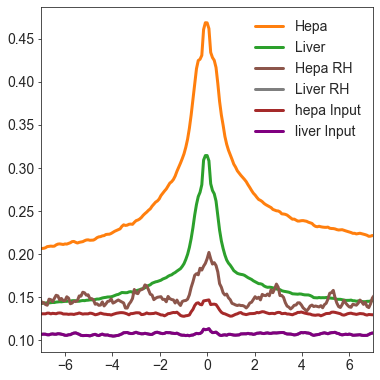

In [27]:
fig, ax = plt.subplots(ncols =1, nrows=1, figsize=(5.5,5.5))

X = np.arange(-7.5,7.5,0.075)

g= liver_center['mean_hepa'].loc[(liver_center['mean_hepa'].mean(axis=1) < liver_center['mean_hepa'].mean(axis=1).quantile(0.99)),:].mean(axis=0)
h= liver_center['mean_liver'].loc[(liver_center['mean_liver'].mean(axis=1) < liver_center['mean_liver'].mean(axis=1).quantile(0.99)),:].mean(axis=0)
i= liver_center['V1_RNHplus-2_Hepa'].loc[(liver_center['V1_RNHplus-2_Hepa'].mean(axis=1) < liver_center['V1_RNHplus-2_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
j= liver_center['V1_RNHplus-1_L'].loc[(liver_center['V1_RNHplus-1_L'].mean(axis=1) < liver_center['V1_RNHplus-1_L'].mean(axis=1).quantile(0.99)),:].mean(axis=0)
k= liver_center['V1_Input-1_Hepa'].loc[(liver_center['V1_Input-1_Hepa'].mean(axis=1) < liver_center['V1_Input-1_Hepa'].mean(axis=1).quantile(0.99)),:].mean(axis=0)
l= liver_center['V1_Input-1_L'].loc[(liver_center['V1_Input-1_L'].mean(axis=1) < liver_center['V1_Input-1_L'].mean(axis=1).quantile(0.99)),:].mean(axis=0)
palette_tab10 = sns.color_palette("tab10", 10)

ax.set_xlim(-7, 7)
ax.set_xlabel('')
ax.set_ylabel('')

ax.plot(X, g, color = palette_tab10[1], label = 'Hepa', linewidth=3  )
ax.plot(X, h, color = palette_tab10[2], label = 'Liver', linewidth=3)

ax.plot(X, i, color =palette_tab10[5], label = 'Hepa RH', linewidth=3)
ax.plot(X, j, color =palette_tab10[7], label = 'Liver RH', linewidth=3 )
ax.plot(X, k, color = 'brown', label = 'hepa Input', linewidth=3)
ax.plot(X, l, color = 'purple', label = 'liver Input', linewidth=3 )
ax.legend(frameon=False)

fig.tight_layout()
#fig.savefig('DRIP_around_liver_peaks.svg')

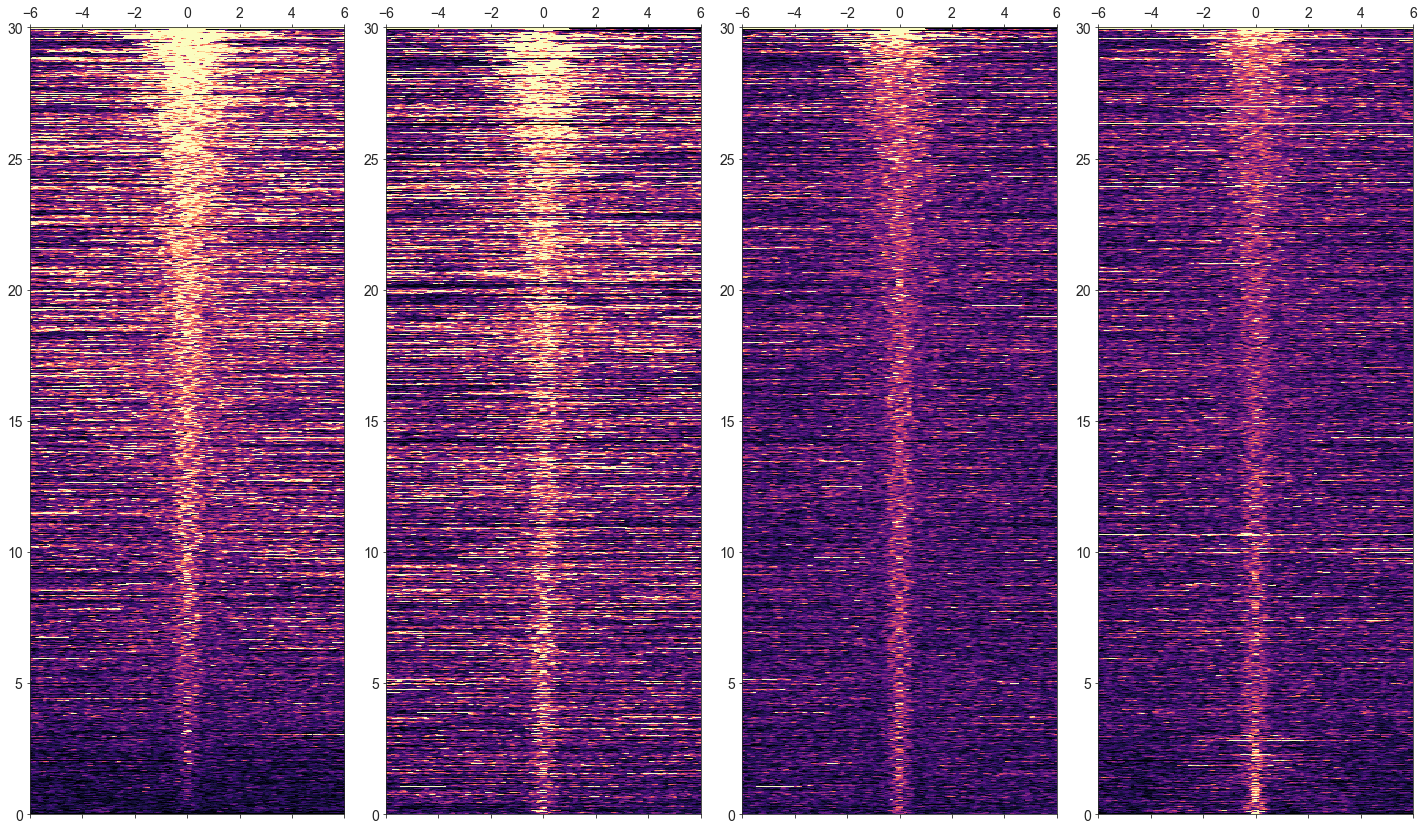

In [20]:
#All liver peaks

fig, ax = plt.subplots(figsize=(20, 52), ncols=4)

ax[0].matshow(liver_center['mean_hepa'].iloc[np.argsort(liver_center['mean_hepa'].iloc[:, 75:125].mean(axis=1))[::-1], :],
            extent = [-6, 6, 0, 30], cmap='magma', vmin=0, vmax=0.6)
ax[1].matshow(liver_center['mean_hepa'].iloc[np.argsort(liver_center['mean_liver'].iloc[:, 75:125].mean(axis=1))[::-1], :],
            extent = [-6, 6, 0, 30], cmap='magma', vmin=0, vmax=0.6)
ax[2].matshow(liver_center['mean_liver'].iloc[np.argsort(liver_center['mean_liver'].iloc[:, 75:125].mean(axis=1))[::-1], :],
            extent = [-6, 6, 0, 30], cmap='magma', vmin=0, vmax=0.6)
ax[3].matshow(liver_center['mean_liver'].iloc[np.argsort(liver_center['mean_hepa'].iloc[:, 75:125].mean(axis=1))[::-1], :],
            extent = [-6, 6, 0, 30], cmap='magma', vmin=0, vmax=0.6)

fig.tight_layout()
#fig.savefig('liver_peak_heatmap.svg')


# HEPA DRIP peaks center and scaled

In [24]:
hepa_center = glob.glob('/Users/madziacrossley/Library/CloudStorage/Box-Box/MPC_files/Desktop_Files/Collaborations/Puzzo_Kay_lab/deeptools_hepa_bin75/*.matrix')
filename_correspondence_hepa_center = {i: sample_extractor.findall(i)[0] for i in hepa_center}


In [25]:
#dict containing genic and intergnic peaks
hepa_center = {}

for filename, samplename in filename_correspondence_hepa_center.items():
    print(samplename)
    hepa_center[samplename] = read_full_file(filename)
    
       # hepa_center[samplename] = read_full_file(filename)

V1_RNH--1_Hepa
V1_RNHplus-1_L
V1_Input-2_L
V1_RNH--2_L
V1_RNH--2_Hepa
V1_Input-1_L
V1_Input-2_Hepa
V1_RNHplus-2_L
V1_RNHplus-1_Hepa
V1_RNHplus-2_Hepa
V1_RNH--1_L
V1_Input-1_Hepa


In [28]:
hepa_center['mean_hepa'] = (hepa_center['V1_RNH--1_Hepa'] + hepa_center['V1_RNH--2_Hepa'])/2
hepa_center['mean_liver'] = (hepa_center['V1_RNH--1_L'] + hepa_center['V1_RNH--2_L'])/2


In [29]:
hepa_center['mean_hepa'].shape

(28717, 200)

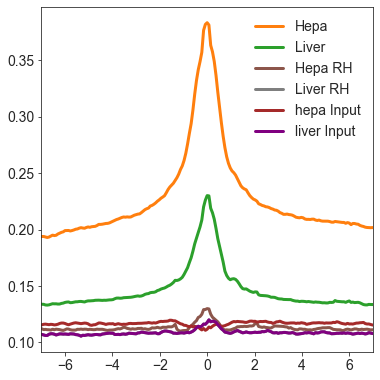

In [31]:
fig, ax = plt.subplots(ncols =1, nrows=1, figsize=(5.5,5.5))

X = np.arange(-7.5,7.5,0.075)

g= hepa_center['mean_hepa'].loc[(hepa_center['mean_hepa'].mean(axis=1) < hepa_center['mean_hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
h= hepa_center['mean_liver'].loc[(hepa_center['mean_liver'].mean(axis=1) < hepa_center['mean_liver'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
i= hepa_center['V1_RNHplus-1_Hepa'].loc[(hepa_center['V1_RNHplus-1_Hepa'].mean(axis=1) < hepa_center['V1_RNHplus-1_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
j= hepa_center['V1_RNHplus-1_L'].loc[(hepa_center['V1_RNHplus-1_L'].mean(axis=1) < hepa_center['V1_RNHplus-1_L'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
k= hepa_center['V1_Input-1_Hepa'].loc[(hepa_center['V1_Input-1_Hepa'].mean(axis=1) < hepa_center['V1_Input-1_Hepa'].mean(axis=1).quantile(0.999)),:].mean(axis=0)
l= hepa_center['V1_Input-1_L'].loc[(hepa_center['V1_Input-1_L'].mean(axis=1) < hepa_center['V1_Input-1_L'].mean(axis=1).quantile(0.999)),:].mean(axis=0)

palette_tab10 = sns.color_palette("tab10", 10)

ax.set_xlim(-7, 7)
ax.set_xlabel('')
ax.set_ylabel('')


ax.plot(X, g, color = palette_tab10[1], label = 'Hepa', linewidth=3  )
ax.plot(X, h, color = palette_tab10[2], label = 'Liver', linewidth=3)

ax.plot(X, i, color =palette_tab10[5], label = 'Hepa RH', linewidth=3)
ax.plot(X, j, color =palette_tab10[7], label = 'Liver RH', linewidth=3 )
ax.plot(X, k, color = 'brown', label = 'hepa Input', linewidth=3)
ax.plot(X, l, color = 'purple', label = 'liver Input', linewidth=3 )
ax.legend(frameon=False)

fig.tight_layout()
#fig.savefig('DRIP_around_hepa_peaks.svg')

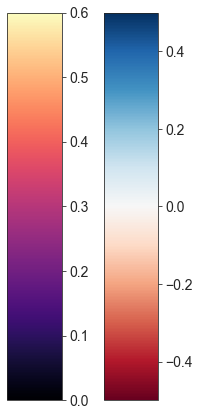

In [138]:
fig, ax = plt.subplots(figsize=(3, 6), ncols=2)
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
norm_2 = mpl.colors.Normalize(vmin = -0.5, vmax=0.5)

cb1 = mpl.colorbar.ColorbarBase(ax[0], cmap=cmap,
                                norm=norm,
                                )

cb2 = mpl.colorbar.ColorbarBase(ax[1], cmap=mpl.cm.RdBu,
                                norm=norm_2,
                                )
fig.tight_layout()
fig.savefig('heatmap_colorbars.svg')

# Peak sizes

In [64]:
bed_cols = ['chr', 'start', 'end', 'name', 'value', 'strand']

hepa_peaks = pd.read_csv('/Users/madziacrossley/Library/CloudStorage/Box-Box/MPC_files/Desktop_Files/Collaborations/Puzzo_Kay_lab/hepa_annotated_peaks.bed', 
                          sep='\t', names = bed_cols)
liver_peaks = pd.read_csv('/Users/madziacrossley/Library/CloudStorage/Box-Box/MPC_files/Desktop_Files/Collaborations/Puzzo_Kay_lab/liver_annotated_peaks.bed', 
                          sep='\t', names = bed_cols)


In [65]:
def peak_length (df):
    df['length'] = df.end-df.start
    return df

In [66]:
hepa_peaks = peak_length(hepa_peaks)
liver_peaks = peak_length(liver_peaks)


In [10]:
hepa_peaks.length.describe()

count    28717.000000
mean      1964.602779
std       2509.776592
min        224.000000
25%        578.000000
50%       1091.000000
75%       2327.000000
max      42429.000000
Name: length, dtype: float64

In [108]:
liver_peaks.length.describe()

count    14908.000000
mean      1446.286289
std       1814.002463
min        234.000000
25%        440.000000
50%        881.000000
75%       1695.000000
max      59575.000000
Name: length, dtype: float64

/Users/madziacrossley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/Users/madziacrossley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


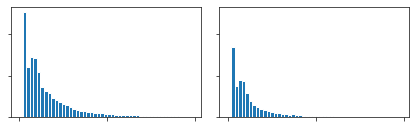

In [6]:
fig, ax = plt.subplots(figsize=(6,2), ncols=2, sharey=True)

ax[0].hist(hepa_peaks.length, bins = np.arange(0, 10000, 200))
ax[1].hist(liver_peaks.length, bins = np.arange(0, 10000, 200))

for ax in ax:
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])

#ax.hist(GL3_peaks_2.length, bins = np.arange(0, 3000, 50))
#ax.set_ylabel('Number of peaks')
#ax.set_xlabel('Peak size (nt)')
#for ax in ax:
 #   ax.set_title('All cytoDRIP peaks')

fig.tight_layout()
fig.savefig('peak_sizes_hepa_liver.png')



In [69]:
len(liver_only)

3598

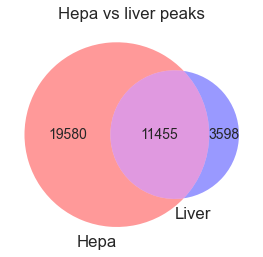

In [78]:
fig, ax = plt.subplots(figsize = (5.8,3.8))

import matplotlib_venn

matplotlib_venn.venn2(subsets = (len(hepa_only), len(liver_only), len(hepa_overlap_liver)), 
                      set_labels = ('Hepa', 'Liver', 'overlap'),
                     set_colors = ('red', 'blue'),
                    ax=ax
                     )

ax.set_title('Hepa vs liver peaks')

fig.tight_layout()
#fig.savefig('peaks_overlaps.svg')

# Comparing nucleotide content

In [38]:
col_names = ['chr', 'start', 'end', 'peak_name', 'value', 'strand', 'pct_at', 'pct_gc', 'num_a', 'num_c', 'num_g',
            'num_t', 'num_n', 'num_other', 'seq_len']

hepa_nuc = pd.read_csv('hepa_annotated_peaks.bed.nuc_content.txt',
                      names = col_names, skiprows=[0], sep='\t')

liver_nuc = pd.read_csv('liver_annotated_peaks.bed.nuc_content.txt',
                      names = col_names, skiprows=[0], sep='\t')

hepa_only_nuc = pd.read_csv('hepa_only_peaks.bed.nuc_content.txt',
                      names = col_names, skiprows=[0], sep='\t')

liver_only_nuc = pd.read_csv('liver_only_peaks.bed.nuc_content.txt',
                      names = col_names, skiprows=[0], sep='\t')

                     

In [39]:
hepa_nuc['peak_type'] = 'hepa'
liver_nuc['peak_type'] = 'liver'
hepa_only_nuc['peak_type'] = 'hepa_only'
liver_only_nuc['peak_type'] = 'liver_only'


In [40]:
nuc_all = pd.concat([hepa_nuc, liver_nuc, 
                     hepa_only_nuc, liver_only_nuc])


In [31]:
import scipy as scipy
from scipy import stats

In [32]:
scipy.stats.mannwhitneyu(nuc_all.loc[nuc_all.peak_type == 'hepa', :]['pct_gc'], nuc_all.loc[nuc_all.peak_type == 'liver', :]['pct_gc'] )


MannwhitneyuResult(statistic=204458880.5, pvalue=1.4357940027519252e-14)

In [22]:
scipy.stats.mannwhitneyu(nuc_all.loc[nuc_all.peak_type == 'hepa', :]['pct_at'], nuc_all.loc[nuc_all.peak_type == 'liver', :]['pct_at'] )


MannwhitneyuResult(statistic=223637438.5, pvalue=1.5942494550389694e-14)

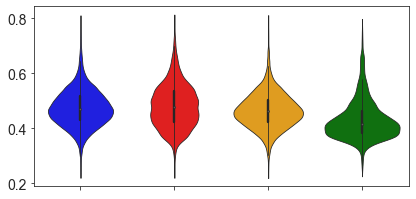

In [41]:
fig, ax = plt.subplots(figsize=(6,3))


sns.violinplot(ax=ax,
               data=nuc_all.loc[nuc_all.peak_type.isin(['hepa', 'liver', 'hepa_only', 'liver_only'])],
            order = ['hepa', 'liver', 'hepa_only', 'liver_only'],
               
            x='peak_type', 
            y='pct_gc',
            width=0.8,
               linewidth=0.8,
            palette=['blue', 'red', 'orange', 'green']
          )
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(['','','',''])
fig.tight_layout()
#fig.savefig('pct_gc_violin_hepa_liver_only.svg', transparent=True)

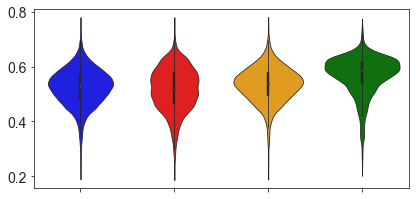

In [42]:
fig, ax = plt.subplots(figsize=(6,3))


sns.violinplot(ax=ax,
               data=nuc_all.loc[nuc_all.peak_type.isin(['hepa', 'liver', 'hepa_only', 'liver_only'])],
            order = ['hepa', 'liver', 'hepa_only', 'liver_only'],
               
            x='peak_type', 
            y='pct_at',
            width=0.8,
               linewidth=0.8,
            palette=['blue', 'red', 'orange', 'green']
          )
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(['','','',''])
fig.tight_layout()
#fig.savefig('pct_at_violin_hepa_liver_only.svg', transparent=True)

In [54]:
scipy.stats.kruskal(hepa_nuc.pct_at, liver_nuc.pct_at, hepa_only_nuc.pct_at, liver_only_nuc.pct_at)

KruskalResult(statistic=1940.334233535956, pvalue=0.0)

In [55]:
scipy.stats.kruskal(hepa_nuc.pct_gc, liver_nuc.pct_gc, hepa_only_nuc.pct_gc, liver_only_nuc.pct_gc)

KruskalResult(statistic=1940.3392681986052, pvalue=0.0)